In [9]:
from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration
import numpy as np

from matplotlib import pyplot as plt

from astropy.wcs import WCS
from astropy.io import fits


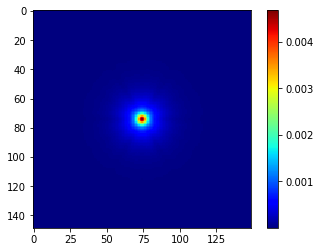

In [10]:
psf = fits.getdata('nuA2dpsf20100101v003.fits', extname='2DPSF_0ARCMIN')

nx, ny = psf.shape

half_ind = np.int(nx*0.5)


cumu_psf = np.cumsum(psf[half_ind, :])
cumu_psf /= cumu_psf.max()

inrange = np.where( (cumu_psf > 0.001) & (cumu_psf < 0.999))

min_ind = min(inrange[0])
max_ind = max(inrange[0])

psf_im = psf.copy()
psf_im = psf_im[min_ind:max_ind, min_ind:max_ind]

psf_im /= np.sum(psf_im)
plt.imshow(psf_im)
plt.colorbar()
plt.show()

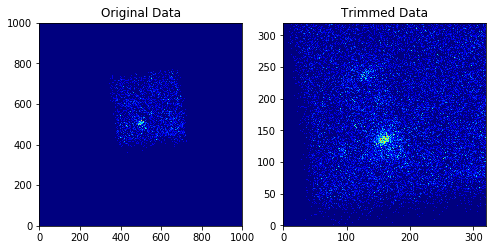

In [11]:
rawdata, hdr= fits.getdata('nu_3-8_cl.evt', header=True)

trim_raw = rawdata.copy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
plt.jet()



ax[0].imshow(rawdata, origin='lower')
ax[0].set_title('Original Data')


centery = 530
sizey = 160
min_indy = centery-sizey
max_indy = centery+sizey

centerx = 500
sizex = 160
min_indx = centerx-sizex
max_indx = centerx+sizex




trim_raw = trim_raw[min_indy:max_indy, min_indx:max_indx]
ax[1].imshow(trim_raw, origin = 'lower')
ax[1].set_title('Trimmed Data')


plt.show()



In [12]:

hdu = fits.open('nu_3-8_cl.evt')[0]
this_wcs = WCS(hdu.header)
image_data = hdu.data



this_wcs.wcs.crval = this_wcs.wcs_pix2world(centerx, centery, 1)

this_wcs.wcs.crpix[0] = sizex
this_wcs.wcs.crpix[1] = sizey

hdr2 = this_wcs.to_header()

fits.writeto('trim_image.fits', trim_raw, hdr2, overwrite=True)


In [13]:
sky_im = conv2(trim_raw, psf_im, 'same')
fits.writeto('smooth_image.fits', sky_im, hdr2, overwrite=True)



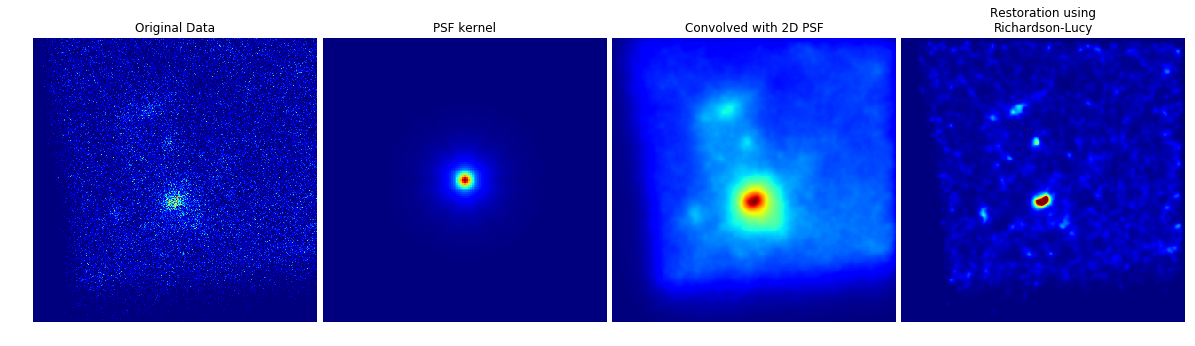

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 10))
plt.jet()

for a in (ax[0], ax[1], ax[2], ax[3]):
       a.axis('off')

ax[0].imshow(trim_raw, origin='lower')
ax[0].set_title('Original Data')

ax[1].imshow(psf_im)
ax[1].set_title('PSF kernel')


ax[2].imshow(sky_im, vmin=sky_im.min(), vmax=sky_im.max(), origin='lower')
ax[2].set_title('Convolved with 2D PSF')

deconv_data = restoration.richardson_lucy(trim_raw / trim_raw.max(), psf_im, iterations=20, clip='False')

ax[3].imshow(deconv_data,origin='lower')
ax[3].set_title('Restoration using\nRichardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

fits.writeto('deconv_image.fits', deconv_data, hdr2, overwrite=True)

